<a href="https://colab.research.google.com/github/ancestor9/2025_Spring_Capstone-Design/blob/main/Week13/1_5_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GAN**

## **Variational Auto Encoder - deep learning**
- Unsupervised learning
- 비선형데이터의 차원축소, 노이즈제거 이미지 복원, 새로운 이미지 생성 알고리즘
<img src='https://blog.kakaocdn.net/dn/qLLF6/btqMOy3Wp7C/Cyi04XYJTecOhJwGlJ71e0/img.png' width=800>

- https://kvfrans.com/variational-autoencoders-explained/

### **A. Autoencoder**

<img src='https://kvfrans.com/content/images/2016/08/autoenc.jpg' width=600>

###**B. Variational Autoencoder**

<img src='https://kvfrans.com/content/images/2016/08/vae.jpg' width=600>

###**C. Generative model using Variational Autoencoder**
<img src= 'https://miro.medium.com/max/1313/1*woWzbXU2bmshM1czEur72g.gif'>

### Scikit-learn implements efficient kernel density estimation
- kde using either a Ball Tree or KD Tree structure, through the KernelDensity estimator.
- The available kernels are shown as belows
- https://scikit-learn.org/stable/modules/density.html#kernel-density

# 📦 1. 필요한 라이브러리 불러오기

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


# 🧠 2. 데이터셋 준비 (MNIST)

In [11]:
# MNIST 데이터셋 로드
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# 데이터 정규화 및 차원 확장
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# 🏗️ 3. 모델 하이퍼파라미터 설정

In [4]:
latent_dim = 2  # 잠재 공간의 차원 수
# 잠재 공간(latent space)의 차원을 2로 설정하여 시각화가 용이하도록 합니다.

# 🧱 4. 인코더 정의
### 예를들어 : 인코더는 입력 이미지를 잠재 공간의 평균(z_mean)과 로그 분산(z_log_var)으로 매핑

In [15]:
def build_encoder(latent_dim):
    encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

encoder = build_encoder(latent_dim)

# 🔁 5. 재매개변수화 트릭

In [16]:
# 재매개변수화 함수 정의
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# 🧱 6. 디코더 정의
### 디코더는 잠재 벡터를 입력으로 받아 원래 이미지로 복원

In [17]:
# 디코더 모델 정의
def build_decoder(latent_dim):
    decoder_inputs = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder

decoder = build_decoder(latent_dim)


# 🔗 7. VAE 모델 구성 및 손실 함수 정의

In [22]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

        # Add the call method for the forward pass
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction # Return the reconstructed output

    def train_step(self, data):
        # Check if data is a tuple (input, target)
        if isinstance(data, tuple):
            data = data[0] # Use only the input data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_sum(kl_loss, axis=1)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Instantiate the VAE model
vae = VAE(encoder, decoder)


# ⚙️ 8. 손실 함수 정의 (재구성 손실 + KL 발산)

In [25]:
# ⚙️ 8. 손실 함수 정의 (재구성 손실 + KL 발산)
vae.compile(optimizer='adam', loss='mse') # Provide a placeholder loss like 'mse'
vae.fit(x_train, x_train, epochs=5, batch_size=128, validation_data=(x_test, x_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 161ms/step - kl_loss: 5.4353 - loss: 162.2973 - reconstruction_loss: 156.8620 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 164ms/step - kl_loss: 5.5990 - loss: 159.7611 - reconstruction_loss: 154.1620 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 162ms/step - kl_loss: 5.7122 - loss: 157.8386 - reconstruction_loss: 152.1265 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 161ms/step - kl_loss: 5.7926 - loss: 156.5445 - reconstruction_loss: 150.7519 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 164ms/step - kl_loss: 5.8355 - loss: 155.6042 - reconstruction_loss: 149.7688 - val_kl_loss: 0.0000e+

# 🖼️ 10. 결과 시각화

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


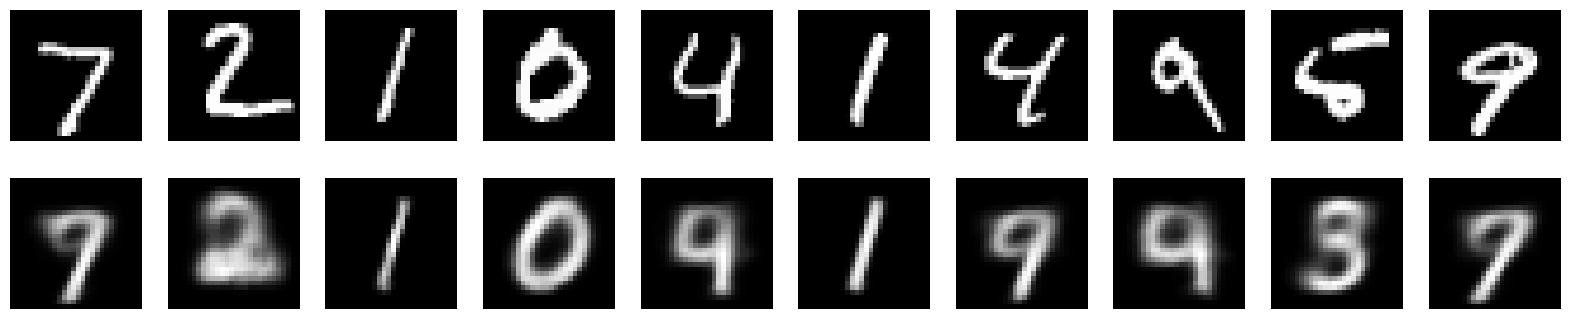

In [26]:
# 테스트 데이터에서 재구성된 이미지 시각화
import matplotlib.pyplot as plt

def plot_reconstructed_images(model, data):
    decoded_imgs = model.predict(data)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # 원본 이미지
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # 재구성된 이미지
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

plot_reconstructed_images(vae, x_test)


# End